### Домашнее задание "Сегментация и детекция объектов"  

Распознавание рукописного ввода на примере базы MNIST  
  
Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.  
  
Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.  

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.  
  
Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.  
  
Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.  

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Algorithm
from sklearn.neighbors import KNeighborsClassifier

# Spliting
from sklearn.model_selection import train_test_split

#PCA
from sklearn.decomposition import PCA

from scipy.stats import uniform

# Prevent warnings
import warnings 
warnings.filterwarnings('ignore')

#### Загружаем исходные данные

In [2]:
train = np.loadtxt(r'C:\Users\Urmas\Desktop\Digital\НЕТОЛОГИЯ. ПРОФЕССИЯ DATA SCIENTIST\Компьютерное зрение\Сегментация и детекция объектов\train.csv', delimiter=',', skiprows=1)
test = np.loadtxt(r'C:\Users\Urmas\Desktop\Digital\НЕТОЛОГИЯ. ПРОФЕССИЯ DATA SCIENTIST\Компьютерное зрение\Сегментация и детекция объектов\test.csv', delimiter=',', skiprows=1)

In [3]:
train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [7., 0., 0., ..., 0., 0., 0.],
       [6., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.]])

In [4]:
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обработки виду
train_img_base = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img_base = np.resize(test, (test.shape[0], 28, 28))

In [6]:
train_img_base.shape

(42000, 28, 28)

#### Визуализируем исходные данные

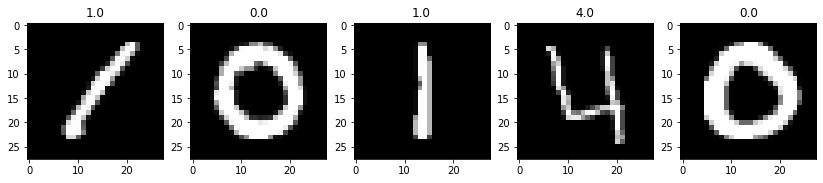

In [7]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img_base[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

#### Предобработка изображений

###### Стандартизация данных

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
s_train = scaler.fit_transform(train[:, 1:])

s_test = scaler.fit_transform(test)

In [9]:
s_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
s_train.shape, s_test.shape

((42000, 784), (28000, 784))

In [11]:
for i in range(784):
    if np.std(s_train[:, i]) != 0:
        s_train[:, i] = (s_train[:, i] - np.mean(s_train[:, i])) / np.std(s_train[:, i])
        
    if np.std(s_test[:, i]) != 0:
        s_test[:, i] = (s_test[:, i] - np.mean(s_test[:, i])) / np.std(s_test[:, i])

###### PCA

In [12]:
pca = PCA(n_components = 3)
s_train_pca = pca.fit_transform(s_train)
#df_train = pd.DataFrame(data = s_train_pca)

s_test_pca = pca.fit_transform(s_test)
#df_test = pd.DataFrame(data = s_test_pca)

In [13]:
# приводим размерность к удобному для обработки виду
train_img = np.resize(s_train_pca, (s_train.shape[0], 28, 28))
test_img = np.resize(s_test_pca, (s_test.shape[0], 28, 28))

In [14]:
train_img.shape

(42000, 28, 28)

##### Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [16]:
train_sobel_x = np.zeros_like(train_img_base)
train_sobel_y = np.zeros_like(train_img_base)
for i in range(len(train_img_base)):
    train_sobel_x[i] = cv2.Sobel(train_img_base[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img_base[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [17]:
test_sobel_x = np.zeros_like(test_img_base)
test_sobel_y = np.zeros_like(test_img_base)
for i in range(len(test_img_base)):
    test_sobel_x[i] = cv2.Sobel(test_img_base[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img_base[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

##### Вычисляем угол и длину вектора градиента

In [18]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

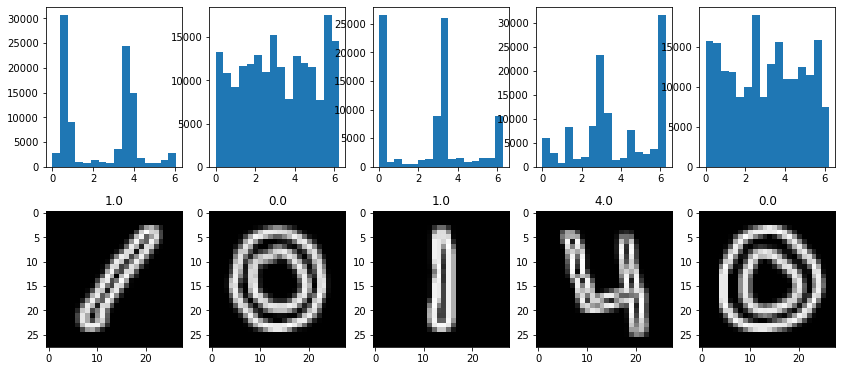

In [19]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

##### Вычисляем гистограммы градиентов

In [20]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img_base), 16))
for i in range(len(train_img_base)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [21]:
test_hist = np.zeros((len(test_img_base), 16))
for i in range(len(test_img_base)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

##### Нормируем вектор гистограммы

In [22]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

In [23]:
train_hist.shape

(42000, 16)

In [72]:
X_train = np.hstack([s_train_pca, train_hist])
X_test = np.hstack([s_test_pca, test_hist])

##### Разбиваем выборку на обучение и валидацию

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    X_train, train_label, test_size=0.2, random_state=42)

In [26]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [27]:
from sklearn.metrics import classification_report

print('Train:')
y_pred = knn.predict(x_train)
print(classification_report(y_train, y_pred))

print('Test:')
y_pred = knn.predict(x_val)
print(classification_report(y_val, y_pred))

Train:
              precision    recall  f1-score   support

         0.0       0.78      0.91      0.84      3316
         1.0       0.95      0.97      0.96      3775
         2.0       0.65      0.68      0.67      3331
         3.0       0.66      0.69      0.67      3414
         4.0       0.67      0.80      0.73      3233
         5.0       0.74      0.63      0.68      3093
         6.0       0.73      0.76      0.75      3352
         7.0       0.80      0.73      0.76      3508
         8.0       0.68      0.55      0.60      3228
         9.0       0.71      0.66      0.69      3350

    accuracy                           0.74     33600
   macro avg       0.74      0.74      0.74     33600
weighted avg       0.74      0.74      0.74     33600

Test:
              precision    recall  f1-score   support

         0.0       0.69      0.84      0.76       816
         1.0       0.96      0.97      0.96       909
         2.0       0.53      0.53      0.53       846
         3.

In [28]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import RobustScaler, MinMaxScaler

from tqdm.notebook import tqdm

In [29]:
fold = 10

models = [SVC(), KNeighborsClassifier(), RandomForestClassifier(), LogisticRegression()]
mnames = ['svm', 'knn', 'random forest', 'logistic']
scalers = [None, StandardScaler(), RobustScaler(), MinMaxScaler()]
snames = ['none', 'std', 'robust', 'minmax']
scores = [[] for _ in range(len(scalers))]
accuracys = [[] for _ in range(len(scalers))]

for model in tqdm(models):
    for ind, scaler in enumerate(scalers):
        if scaler:
            model = Pipeline(steps = [('scaler', scaler), ('model', model)])
                
            cv = StratifiedKFold(n_splits=fold, shuffle = True)
            score = cross_val_score(model, x_val, y_val, cv = cv, scoring = 'accuracy').mean()
            scores[ind].append(score)
            
            model.fit(x_train, y_train)
            pred = model.predict(x_val)
            accuracy = accuracy_score(y_val, pred)
            accuracys[ind].append(accuracy)
            
print(pd.DataFrame(scores, index = snames, columns = mnames).T, 
      pd.DataFrame(accuracys, index = snames, columns = mnames).T, sep='\n\n')


               none       std    robust    minmax
svm             NaN  0.839048  0.838452  0.837738
knn             NaN  0.772381  0.770357  0.769524
random forest   NaN  0.805000  0.805833  0.806905
logistic        NaN  0.768452  0.769524  0.768452

               none       std    robust    minmax
svm             NaN  0.863810  0.863810  0.863810
knn             NaN  0.806905  0.806905  0.806905
random forest   NaN  0.833929  0.834405  0.834524
logistic        NaN  0.773333  0.773333  0.773333


In [30]:
model = Pipeline(steps = [('scaler', RobustScaler()), ('model', SVC())])
            
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(accuracy_score(y_val, pred))

0.8642857142857143


In [31]:
model = Pipeline(steps = [('scaler', StandardScaler()), ('model', SVC())])
            
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(accuracy_score(y_val, pred))

0.8638095238095238


In [32]:
# params for SVC
params = {
    'kernel':['rbf', 'linear'],
    'gamma':['auto', uniform(loc=0, scale=4), 10, 100],
    'C':[uniform(loc=0, scale=4), 10, 100, 1000]
}


In [33]:
for i in tqdm(range(1)):
    res = RandomizedSearchCV(estimator=SVC(), param_distributions = params, 
                         cv=10, scoring = 'accuracy', n_jobs=-1).fit(x_train, y_train)

In [34]:
print(res.best_score_, res.best_params_)

0.8276190476190475 {'kernel': 'rbf', 'gamma': 'auto', 'C': 10}


In [42]:
# params2 for SVC
params2 = {
    'kernel':['rbf'],
    'gamma':['auto'],
    'C':[10, 20, 30, 40, 50]
}

In [43]:
for i in tqdm(range(1)):
    res2 = RandomizedSearchCV(estimator=SVC(), param_distributions = params2, 
                         cv=10, scoring = 'accuracy', n_jobs=-1).fit(x_train, y_train)

In [44]:
print(res2.best_score_, res2.best_params_)

0.8399404761904762 {'kernel': 'rbf', 'gamma': 'auto', 'C': 40}


In [48]:
algo = SVC(kernel='rbf',gamma='auto',C=40)
algo.fit(x_train, y_train)

SVC(C=40, gamma='auto')

In [49]:
print('Train:')
y_pred_algo = algo.predict(x_train)
print(classification_report(y_train, y_pred_algo))

print('Test:')
y_pred_algo = algo.predict(x_val)
print(classification_report(y_val, y_pred_algo))

Train:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      3316
         1.0       0.99      0.99      0.99      3775
         2.0       0.82      0.80      0.81      3331
         3.0       0.86      0.85      0.86      3414
         4.0       0.90      0.91      0.90      3233
         5.0       0.88      0.90      0.89      3093
         6.0       0.89      0.93      0.91      3352
         7.0       0.94      0.89      0.92      3508
         8.0       0.85      0.84      0.85      3228
         9.0       0.88      0.89      0.88      3350

    accuracy                           0.90     33600
   macro avg       0.90      0.90      0.90     33600
weighted avg       0.90      0.90      0.90     33600

Test:
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       816
         1.0       0.98      0.98      0.98       909
         2.0       0.73      0.71      0.72       846
         3.

#### Предсказания на тестовыйх данных

In [118]:
y_pred_test = algo.predict(X_test)

##### Готовим файл для отправки

In [119]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

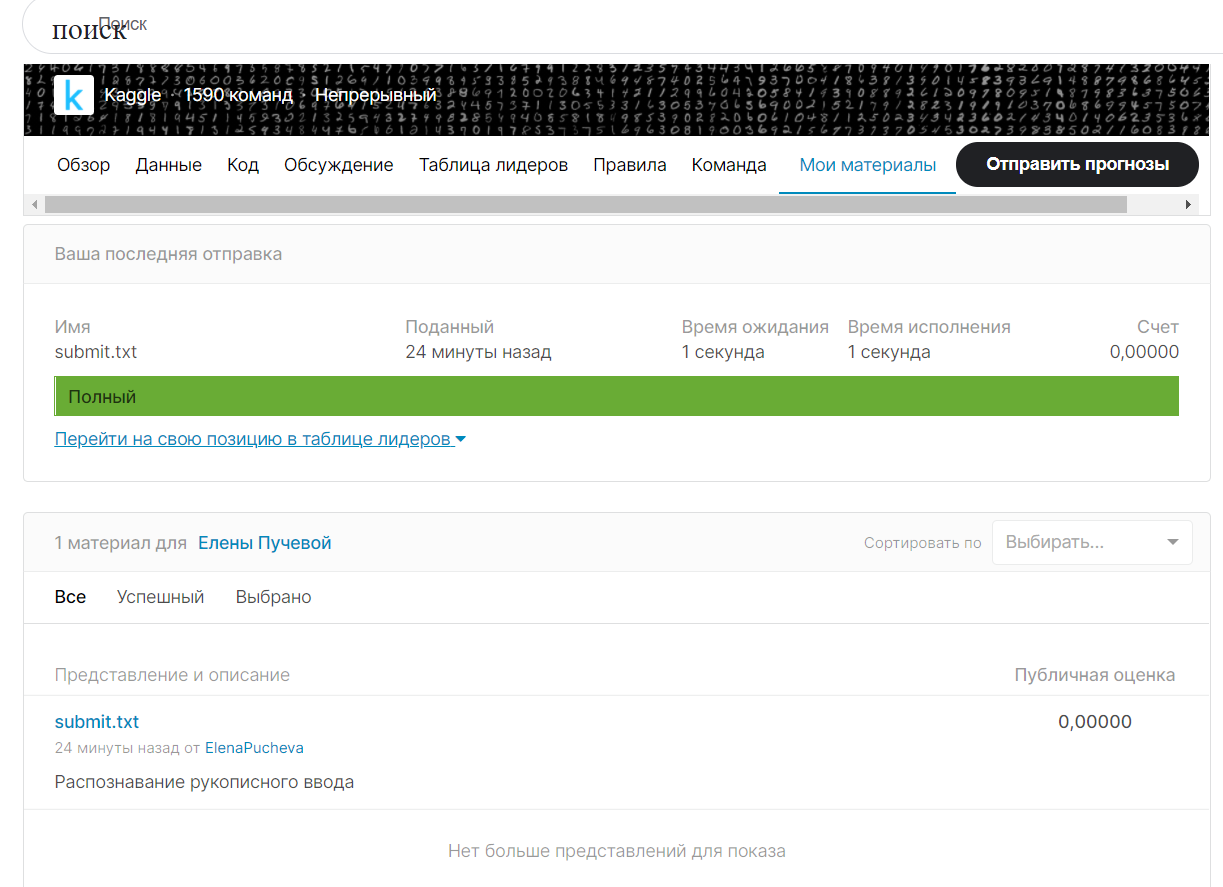